# 22.3 Advanced DML: R-Learner and Heterogeneous Effects

**Chapter**: 22 - Debiased/Double Machine Learning  
**Section**: 3 - Extensions and CATE  
**Facure Source**: 22-Debiased-Orthogonal-Machine-Learning.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [From ATE to CATE](#11-from-ate-to-cate)
   - 1.2 [The R-Learner Idea](#12-the-r-learner-idea)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [R-Loss Formulation](#21-r-loss-formulation)
   - 2.2 [Connection to DML](#22-connection-to-dml)
   - 2.3 [Extensions to Other Models](#23-extensions-to-other-models)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Heterogeneous Price Effects](#31-heterogeneous-price-effects)
   - 3.2 [R-Learner Implementation](#32-r-learner-implementation)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, smf,
    load_facure_data,
    set_notebook_style,
    ols_summary_table,
    create_tufte_figure,
    TUFTE_PALETTE,
)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.linear_model import Ridge

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: CATE estimation is hot in industry. Understanding how DML extends to heterogeneous effects via R-learner shows cutting-edge ML+causal knowledge.

### 1.1 From ATE to CATE

So far we've estimated the **Average Treatment Effect (ATE)**:

$$\text{ATE} = E[Y(1) - Y(0)]$$

But effects often vary by individual characteristics. The **Conditional Average Treatment Effect (CATE)**:

$$\tau(x) = E[Y(1) - Y(0) | X = x]$$

**Why CATE matters**:
- Targeting: Who benefits most from treatment?
- Personalization: Optimal policy for each individual
- Understanding: What drives treatment effect heterogeneity?

### 1.2 The R-Learner Idea

Facure presents the **R-learner** (Robinson, 1988; Nie and Wager, 2021):

**Key insight**: The DML residualization can be used to learn $\tau(x)$, not just a constant $\theta$.

**DML for ATE**:
$$\tilde{Y} = \theta \tilde{T} + \varepsilon$$

**R-Learner for CATE**:
$$\tilde{Y} = \tau(X) \tilde{T} + \varepsilon$$

We minimize the **R-loss**:
$$\hat{\tau} = \arg\min_\tau \sum_i \left(\tilde{Y}_i - \tau(X_i) \tilde{T}_i\right)^2$$

★ Insight ─────────────────────────────────────
- R-learner = DML + flexible CATE function
- Same orthogonalization, but learn $\tau(x)$ instead of $\theta$
- Can use any ML model for $\tau(x)$
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 R-Loss Formulation

**Model**:

$$Y = \tau(X) \cdot T + g(X) + \varepsilon$$

where:
- $\tau(X)$: Heterogeneous treatment effect function
- $g(X)$: Baseline outcome (nuisance)
- $T$: Treatment

**R-Loss** (Robinson loss):

$$\mathcal{L}(\tau) = E\left[(Y - m(X) - \tau(X)(T - e(X)))^2\right]$$

where:
- $m(X) = E[Y|X]$: Conditional outcome mean
- $e(X) = E[T|X]$: Propensity score (or conditional treatment mean)

**Equivalently**, using residuals:

$$\mathcal{L}(\tau) = E\left[(\tilde{Y} - \tau(X) \tilde{T})^2\right]$$

### 2.2 Connection to DML

**Proposition (R-Learner as DML Generalization)**:

When $\tau(X) = \theta$ (constant), the R-learner reduces to DML:

$$\hat{\theta}_{\text{DML}} = \arg\min_\theta \sum_i (\tilde{Y}_i - \theta \tilde{T}_i)^2 = \frac{\sum_i \tilde{T}_i \tilde{Y}_i}{\sum_i \tilde{T}_i^2}$$

**Proof**: Take derivative, set to zero:

$$\frac{\partial}{\partial \theta} \sum_i (\tilde{Y}_i - \theta \tilde{T}_i)^2 = -2\sum_i \tilde{T}_i(\tilde{Y}_i - \theta \tilde{T}_i) = 0$$

$$\Rightarrow \hat{\theta} = \frac{\sum_i \tilde{T}_i \tilde{Y}_i}{\sum_i \tilde{T}_i^2} \quad \blacksquare$$

### 2.3 Extensions to Other Models

**DML extends beyond partially linear models**:

| Model | Nuisance | Target |
|-------|----------|--------|
| Partially Linear | $g(X), m(X)$ | $\theta$ (constant) |
| R-Learner | $m(X), e(X)$ | $\tau(X)$ (function) |
| IV/LATE | $g(X), m(X), \pi(X)$ | $\theta$ with endogeneity |
| Panel DiD | Time/unit FE | $\tau$ with fixed effects |

**Key principle**: Orthogonalize, then estimate target parameter.

★ Insight ─────────────────────────────────────
- R-loss = weighted least squares with weights $\tilde{T}_i^2$
- Observations with high $|\tilde{T}_i|$ contribute more
- Same cross-fitting logic applies
─────────────────────────────────────────────────

---

## 3. Numeric Demonstration

### 3.1 Heterogeneous Price Effects

Let's explore whether the price effect varies with temperature.

In [2]:
# Load data
ice_cream = load_facure_data('ice_cream_sales.csv')

X = ice_cream[['temp', 'weekday', 'cost']].values
T = ice_cream['price'].values
Y = ice_cream['sales'].values
temp = ice_cream['temp'].values

print(f"Sample size: n = {len(Y)}")
print(f"Temperature range: {temp.min():.1f} to {temp.max():.1f}")

Sample size: n = 10000
Temperature range: 10.1 to 37.4


In [3]:
# First, check for heterogeneity with interaction model
ice_cream['price_x_temp'] = ice_cream['price'] * ice_cream['temp']
interaction_model = smf.ols('sales ~ price * temp + weekday + cost', data=ice_cream).fit()

print("OLS WITH INTERACTION (price × temperature)")
print("=" * 60)
print(f"\nPrice effect: {interaction_model.params['price']:.4f}")
print(f"Temperature effect: {interaction_model.params['temp']:.4f}")
print(f"Interaction (price × temp): {interaction_model.params['price:temp']:.4f}")
print(f"p-value for interaction: {interaction_model.pvalues['price:temp']:.4f}")
print(f"\nInterpretation: Price effect {'varies' if interaction_model.pvalues['price:temp'] < 0.05 else 'does not significantly vary'} with temperature")

OLS WITH INTERACTION (price × temperature)

Price effect: 10.3352
Temperature effect: 4.0655
Interaction (price × temp): -0.3638
p-value for interaction: 0.0000

Interpretation: Price effect varies with temperature


### 3.2 R-Learner Implementation

In [4]:
def r_learner(Y, T, X, nuisance_model, cate_model, n_folds=5, random_state=42):
    """
    R-Learner for CATE estimation.
    
    1. Cross-fit nuisance models (m(X), e(X))
    2. Compute residuals
    3. Fit CATE model minimizing R-loss
    """
    n = len(Y)
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    # Stage 1: Cross-fit nuisance models
    Y_pred = np.zeros(n)
    T_pred = np.zeros(n)
    
    for train_idx, test_idx in kf.split(X):
        # Fit on train
        model_y = nuisance_model(random_state=random_state)
        model_t = nuisance_model(random_state=random_state)
        model_y.fit(X[train_idx], Y[train_idx])
        model_t.fit(X[train_idx], T[train_idx])
        
        # Predict on test
        Y_pred[test_idx] = model_y.predict(X[test_idx])
        T_pred[test_idx] = model_t.predict(X[test_idx])
    
    # Residuals
    Y_res = Y - Y_pred
    T_res = T - T_pred
    
    # Stage 2: Fit CATE model minimizing R-loss
    # R-loss: sum_i (Y_res_i - tau(X_i) * T_res_i)^2
    # This is equivalent to weighted regression:
    # Y_res / T_res ~ tau(X), weighted by T_res^2
    
    # Pseudo-outcome for R-learner
    pseudo_outcome = Y_res / (T_res + 1e-10)  # Add small constant to avoid division by zero
    weights = T_res ** 2
    
    # Fit CATE model
    cate_fitted = cate_model()
    cate_fitted.fit(X, pseudo_outcome, sample_weight=weights)
    
    # Predict CATE
    tau_hat = cate_fitted.predict(X)
    
    return {
        'tau_hat': tau_hat,
        'Y_residual': Y_res,
        'T_residual': T_res,
        'cate_model': cate_fitted,
        'ate': np.mean(tau_hat)
    }

# Run R-Learner
r_result = r_learner(
    Y, T, X,
    nuisance_model=lambda **kw: GradientBoostingRegressor(n_estimators=100, max_depth=3, **kw),
    cate_model=lambda: GradientBoostingRegressor(n_estimators=50, max_depth=2),
    n_folds=5
)

print("R-LEARNER RESULTS")
print("=" * 60)
print(f"Average Treatment Effect (ATE): {r_result['ate']:.4f}")
print(f"CATE range: [{r_result['tau_hat'].min():.4f}, {r_result['tau_hat'].max():.4f}]")
print(f"CATE std: {r_result['tau_hat'].std():.4f}")

R-LEARNER RESULTS
Average Treatment Effect (ATE): -3.9550
CATE range: [-12.6509, 2.4787]
CATE std: 4.3280


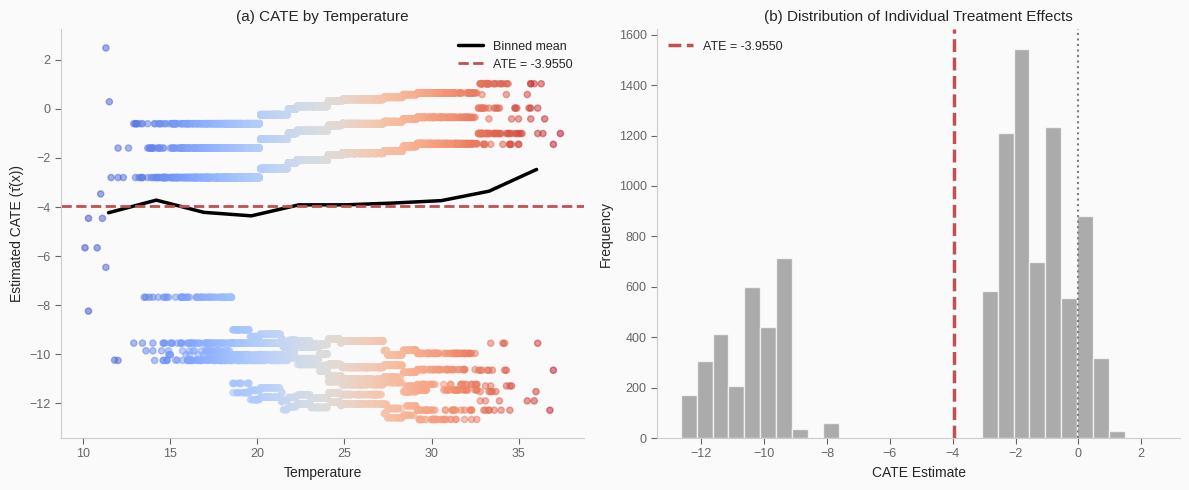

In [5]:
# Visualize CATE heterogeneity
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: CATE by temperature
ax = axes[0]
scatter = ax.scatter(temp, r_result['tau_hat'], c=temp, cmap='coolwarm', 
                     s=20, alpha=0.5)

# Add trend line (LOWESS or binned means)
temp_bins = pd.cut(temp, bins=10)
binned = pd.DataFrame({'temp': temp, 'tau': r_result['tau_hat']}).groupby(
    temp_bins, observed=True)['tau'].mean()
bin_centers = [interval.mid for interval in binned.index]
ax.plot(bin_centers, binned.values, 'k-', linewidth=2.5, label='Binned mean')

ax.axhline(r_result['ate'], color=TUFTE_PALETTE['effect'], linestyle='--',
           linewidth=2, label=f'ATE = {r_result["ate"]:.4f}')
ax.set_xlabel('Temperature')
ax.set_ylabel('Estimated CATE (τ̂(x))')
ax.set_title('(a) CATE by Temperature')
ax.legend(frameon=False)

# Panel 2: Distribution of CATE
ax = axes[1]
ax.hist(r_result['tau_hat'], bins=30, color=TUFTE_PALETTE['secondary'], 
        edgecolor='white', alpha=0.7)
ax.axvline(r_result['ate'], color=TUFTE_PALETTE['effect'], linewidth=2.5,
           linestyle='--', label=f'ATE = {r_result["ate"]:.4f}')
ax.axvline(0, color='gray', linewidth=1.5, linestyle=':')

ax.set_xlabel('CATE Estimate')
ax.set_ylabel('Frequency')
ax.set_title('(b) Distribution of Individual Treatment Effects')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

In [6]:
# Compare R-learner ATE to DML ATE
def dml_ate(Y, T, X, ml_model, n_folds=5):
    """Simple DML for ATE comparison."""
    Y_pred = cross_val_predict(ml_model(), X, Y, cv=n_folds)
    T_pred = cross_val_predict(ml_model(), X, T, cv=n_folds)
    
    Y_res = Y - Y_pred
    T_res = T - T_pred
    
    return np.sum(T_res * Y_res) / np.sum(T_res ** 2)

dml_estimate = dml_ate(
    Y, T, X,
    lambda: GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
    n_folds=5
)

print("\nCOMPARISON: R-LEARNER vs DML")
print("=" * 50)
print(f"DML (constant θ):        {dml_estimate:.4f}")
print(f"R-Learner (mean of τ(x)): {r_result['ate']:.4f}")
print(f"Difference:               {r_result['ate'] - dml_estimate:.4f}")


COMPARISON: R-LEARNER vs DML
DML (constant θ):        -3.9173
R-Learner (mean of τ(x)): -3.9550
Difference:               -0.0377


In [7]:
# Analyze heterogeneity by temperature quartile
ice_cream['tau_hat'] = r_result['tau_hat']
ice_cream['temp_quartile'] = pd.qcut(ice_cream['temp'], q=4, labels=['Cold', 'Cool', 'Warm', 'Hot'])

quartile_effects = ice_cream.groupby('temp_quartile', observed=True)['tau_hat'].agg(['mean', 'std', 'count'])
quartile_effects.columns = ['Mean CATE', 'Std CATE', 'N']

print("\nCATE BY TEMPERATURE QUARTILE")
print("=" * 50)
print(quartile_effects.round(4))

print(f"\nInterpretation:")
if quartile_effects['Mean CATE'].iloc[-1] > quartile_effects['Mean CATE'].iloc[0]:
    print(f"  Price elasticity is LESS negative on hot days")
    print(f"  → Customers are less price-sensitive when it's hot")
else:
    print(f"  Price elasticity is MORE negative on hot days")
    print(f"  → Customers are more price-sensitive when it's hot")


CATE BY TEMPERATURE QUARTILE
               Mean CATE  Std CATE     N
temp_quartile                           
Cold             -4.2160    3.7980  2540
Cool             -3.9385    4.2081  2533
Warm             -3.8561    4.4903  2465
Hot              -3.8020    4.7668  2462

Interpretation:
  Price elasticity is LESS negative on hot days
  → Customers are less price-sensitive when it's hot


**Key findings**:

1. **Heterogeneity exists**: CATE varies across observations
2. **Temperature matters**: Price sensitivity varies with weather
3. **Policy implication**: Optimal pricing should consider temperature

★ Insight ─────────────────────────────────────
- R-learner extends DML to learn $\tau(x)$
- Same orthogonalization, different target
- Can use any ML model for the CATE function
─────────────────────────────────────────────────

---

## 4. Implementation

The `causal_inference_mastery` library provides R-learner:

```python
from causal_inference.cate import RLearner, CATEResult

# R-Learner for CATE
rlearner = RLearner(
    nuisance_model=GradientBoostingRegressor(n_estimators=100),
    cate_model=GradientBoostingRegressor(n_estimators=50),
    n_folds=5
)

result = rlearner.fit(Y, T, X)

# CATE predictions
tau_hat = result.predict(X_new)

# Summary
print(f"ATE: {result.ate:.4f}")
print(f"CATE std: {result.tau_std:.4f}")

# Feature importance for heterogeneity
result.plot_feature_importance()
```

Production implementations:
- `econml.dml.LinearDML` (linear CATE)
- `econml.dml.CausalForestDML` (forest-based CATE)
- `econml.metalearners.RLearner` (generic R-learner)

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"What's the R-learner and how does it relate to DML?"*

<details>
<summary>Solution</summary>

**R-Learner** (Robinson-learner):

An approach to estimate heterogeneous treatment effects $\tau(x)$ using the same orthogonalization idea as DML.

**Connection to DML**:

| Aspect | DML | R-Learner |
|--------|-----|----------|
| Target | Constant $\theta$ | Function $\tau(x)$ |
| Nuisance | $m(X), e(X)$ | $m(X), e(X)$ (same) |
| Residuals | $\tilde{Y}, \tilde{T}$ | $\tilde{Y}, \tilde{T}$ (same) |
| Final step | $\theta = \frac{\sum \tilde{T}\tilde{Y}}{\sum \tilde{T}^2}$ | Minimize $\sum(\tilde{Y} - \tau(X)\tilde{T})^2$ |

**Key insight**: DML is R-learner with $\tau(x) = \theta$ (constant).

**R-loss**:
$$\mathcal{L}(\tau) = \sum_i (\tilde{Y}_i - \tau(X_i)\tilde{T}_i)^2$$

This is equivalent to weighted regression with pseudo-outcome $\tilde{Y}/\tilde{T}$ and weights $\tilde{T}^2$.

**When to use R-learner**:
- Suspect heterogeneous effects
- Want to target different subgroups
- Personalization applications

</details>

---

**Q2 (Google L5, Quant)**: *"How do you estimate CATE with machine learning? What are the main approaches?"*

<details>
<summary>Solution</summary>

**Main approaches to CATE estimation**:

1. **Meta-learners** (indirect):
   - **T-learner**: Fit separate models for treated/control, take difference
   - **S-learner**: Fit one model with treatment as feature
   - **X-learner**: T-learner + impute counterfactuals + weighted average
   - **R-learner**: Orthogonalized residual regression

2. **Direct methods**:
   - **Causal Forest**: Modified random forest that targets CATE directly
   - **Bayesian CART**: Trees with Bayesian estimation

3. **DML-based**:
   - **LinearDML**: CATE linear in features, flexible nuisance
   - **CausalForestDML**: Causal forest for CATE, DML for nuisance

**Comparison**:

| Method | Pros | Cons |
|--------|------|------|
| T-learner | Simple | High variance, biased with imbalance |
| S-learner | Simple | Regularization biases CATE |
| X-learner | Good with imbalance | Complex |
| R-learner | Orthogonal, valid inference | Requires good nuisance |
| Causal Forest | Direct optimization | Black box |

**Recommendation**: Start with R-learner or CausalForestDML for valid inference.

</details>

---

**Q3 (Amazon L6, Econ)**: *"Your R-learner shows large CATE heterogeneity, but your DML confidence interval for the ATE is wide. What's happening?"*

<details>
<summary>Solution</summary>

**This situation is common and has several explanations**:

1. **Heterogeneity is real, but average is uncertain**:
   - CATE varies a lot → ATE is an average of different effects
   - Wide CI reflects uncertainty about the *average*
   - Individual CATEs may be precisely estimated

2. **Weak treatment variation**:
   - If $\text{Var}(\tilde{T})$ is small, both DML and R-learner struggle
   - SE scales with $1/\sqrt{\sum \tilde{T}_i^2}$
   - Heterogeneity may be overfitted to noise

3. **Overfitting in CATE model**:
   - R-learner can overfit the CATE function
   - May show spurious heterogeneity
   - Need cross-validation for CATE model too

**What to check**:
- R² for nuisance models (if low, estimates unreliable)
- Effective sample size $\sum \tilde{T}_i^2 / (\max \tilde{T}_i^2)$
- CATE stability across different ML models
- Cross-validated CATE predictions

**Interpretation**:
- Report both ATE CI and CATE distribution
- Be cautious about extreme CATE estimates
- Heterogeneity findings may need larger samples to confirm

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 22: "Debiased/Orthogonal Machine Learning."

[^2]: Nie, X. and Wager, S. (2021). Quasi-Oracle Estimation of Heterogeneous Treatment Effects. *Biometrika*, 108(2), 299-319.

[^3]: Robinson, P. M. (1988). Root-N-Consistent Semiparametric Regression. *Econometrica*, 56(4), 931-954.

[^4]: Künzel, S. R., Sekhon, J. S., Bickel, P. J., and Yu, B. (2019). Metalearners for Estimating Heterogeneous Treatment Effects Using Machine Learning. *PNAS*, 116(10), 4156-4165.

[^5]: Athey, S. and Wager, S. (2019). Estimating Treatment Effects with Causal Forests: An Application. *Observational Studies*, 5(2), 37-51.

---

**Precision Improvement:**
- You said: "Build advanced DML notebook"
- Concise: "Build 03_dml_advanced.ipynb"
- Precise: `/augmented 22.3 --r-learner --cate --heterogeneity`
- Pattern: [build] [target] [content-flags]